# Data Exploration and Preprocessing

The main objective of this notebook is to explore the data and preprocess it for the further analysis. The data is provided in the form of a CSV file. The data is composed by hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The goal is to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

The dataset was obtained from the [Kaggle Bike Sharing Demand competition](https://www.kaggle.com/c/bike-sharing-demand). 

## Library and data import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import awswrangler as wr
from sklearn.preprocessing import LabelEncoder

Export the necessary environment variables for working with Minio.

In [2]:
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000

env: AWS_ACCESS_KEY_ID=minio
env: AWS_SECRET_ACCESS_KEY=minio123
env: MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
env: AWS_ENDPOINT_URL_S3=http://localhost:9000


Load the training data

In [3]:
train_data_df = pd.read_csv('../data/train.csv')

In [4]:
train_data_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


As we can see, the dataset is composed by various columns. Some of them are numerical continuous, others are numerical discrete, and one of them is a datetime column. 

In [6]:
train_data_df.isnull().any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

Fortunately, there are no missing values in the dataset. Then, we can proceed with further analysis.

In [7]:
for column in train_data_df.columns:
    print(f'{column} has: {len(train_data_df[column].unique()) } unique values')

datetime has: 10886 unique values
season has: 4 unique values
holiday has: 2 unique values
workingday has: 2 unique values
weather has: 4 unique values
temp has: 49 unique values
atemp has: 60 unique values
humidity has: 89 unique values
windspeed has: 28 unique values
casual has: 309 unique values
registered has: 731 unique values
count has: 822 unique values


Next, unique values of the categorical columns are displayed.

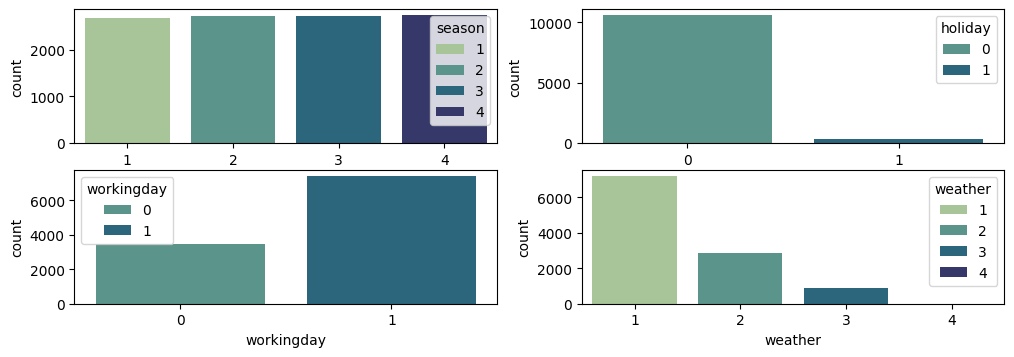

In [8]:
# Configure the size of the plot
plt.figure(figsize=(12,8))

# Initialize the counter
counter = 1

for col in train_data_df.columns:
    # Consider only low cardinality columns
    if col not in ['datetime', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour', 'year', 'month', 'weekday']:
        plt.subplot(4, 2, counter)
        sns.countplot(x=col, data=train_data_df, palette='crest', hue=col)
        counter += 1

# Display the plot
plt.show()

Show the distribution of high cardinality columns

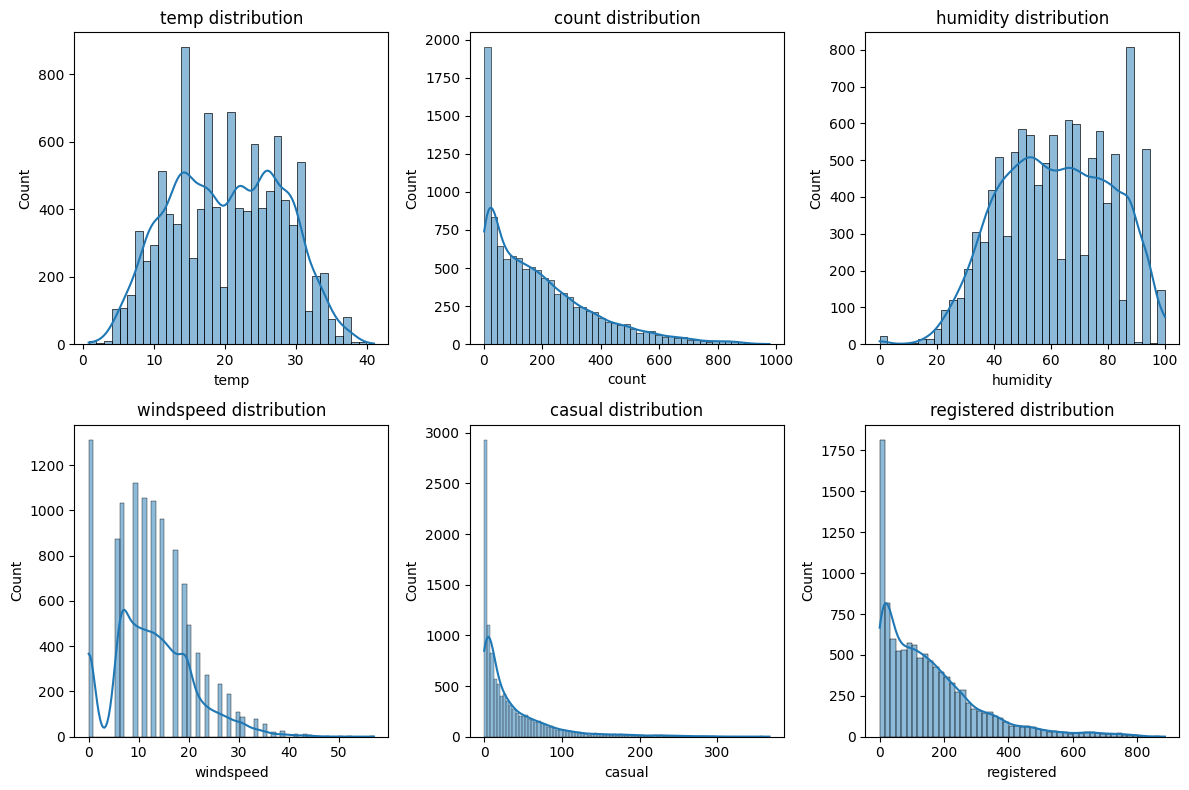

In [9]:
# Configure the size of the plot
plt.figure(figsize=(12, 8))

# Initialize the counter
counter = 1

for col in ['temp', 'count', 'humidity', 'windspeed', 'casual', 'registered']:
    plt.subplot(2, 3, counter)
    sns.histplot(train_data_df[col], kde=True)
    plt.title(f'{col} distribution')
    counter += 1

# Adjust layout
plt.tight_layout()
plt.show()

## Feature Engineering

The datetime column can be further processed to extract more information. For example, we can extract the year, month, day, hour, and weekday from the datetime column. 

In [10]:
# Ensure the datetime column is in datetime format
train_data_df['datetime'] = pd.to_datetime(train_data_df['datetime'])

# Extract year, month, weekday, weekend, and hour
train_data_df['year'] = train_data_df['datetime'].dt.year
train_data_df['month'] = train_data_df['datetime'].dt.month
train_data_df['weekday'] = train_data_df['datetime'].dt.weekday
train_data_df['hour'] = train_data_df['datetime'].dt.hour

# Drop the datetime column
train_data_df = train_data_df.drop('datetime', axis=1)

# Display the first few rows to verify
train_data_df.sample(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,weekday,hour
6478,1,0,1,1,11.48,12.880,61,22.0028,0,3,3,2012,3,2,4
907,1,0,1,1,9.02,10.605,55,16.9979,1,39,40,2011,3,2,6
1877,2,0,1,1,13.94,15.910,66,16.9979,0,4,4,2011,5,3,3
2483,2,0,0,1,30.34,34.090,62,8.9981,59,171,230,2011,6,5,9
9503,3,0,1,1,21.32,25.000,59,15.0013,39,758,797,2012,9,2,8
857,1,0,0,1,16.40,20.455,15,22.0028,0,3,3,2011,2,5,4
3444,3,0,0,2,29.52,34.850,74,15.0013,97,163,260,2011,8,5,10
10367,4,0,0,1,13.94,15.910,49,15.0013,48,200,248,2012,11,5,9
8875,3,0,0,1,26.24,30.305,69,6.0032,2,8,10,2012,8,6,4
6169,1,0,1,1,4.10,5.305,54,12.9980,1,194,195,2012,2,0,7


In [11]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int32  
 12  month       10886 non-null  int32  
 13  weekday     10886 non-null  int32  
 14  hour        10886 non-null  int32  
dtypes: float64(3), int32(4), int64(8)
memory usage: 1.1 MB


Furthermore, analyzing the distribution of the columns `count`, `casual`, and `registered`, we can apply a log transformation to them. This will help to normalize its distributions.

In [14]:
train_data_df['log_count'] = np.log(train_data_df['count'] + 1)
train_data_df['log_casual'] = np.log(train_data_df['casual'] + 1)
train_data_df['log_registered'] = np.log(train_data_df['registered'] + 1)

# Drop the count, casual, and registered columns
train_data_df = train_data_df.drop(['count', 'casual', 'registered'], axis=1)

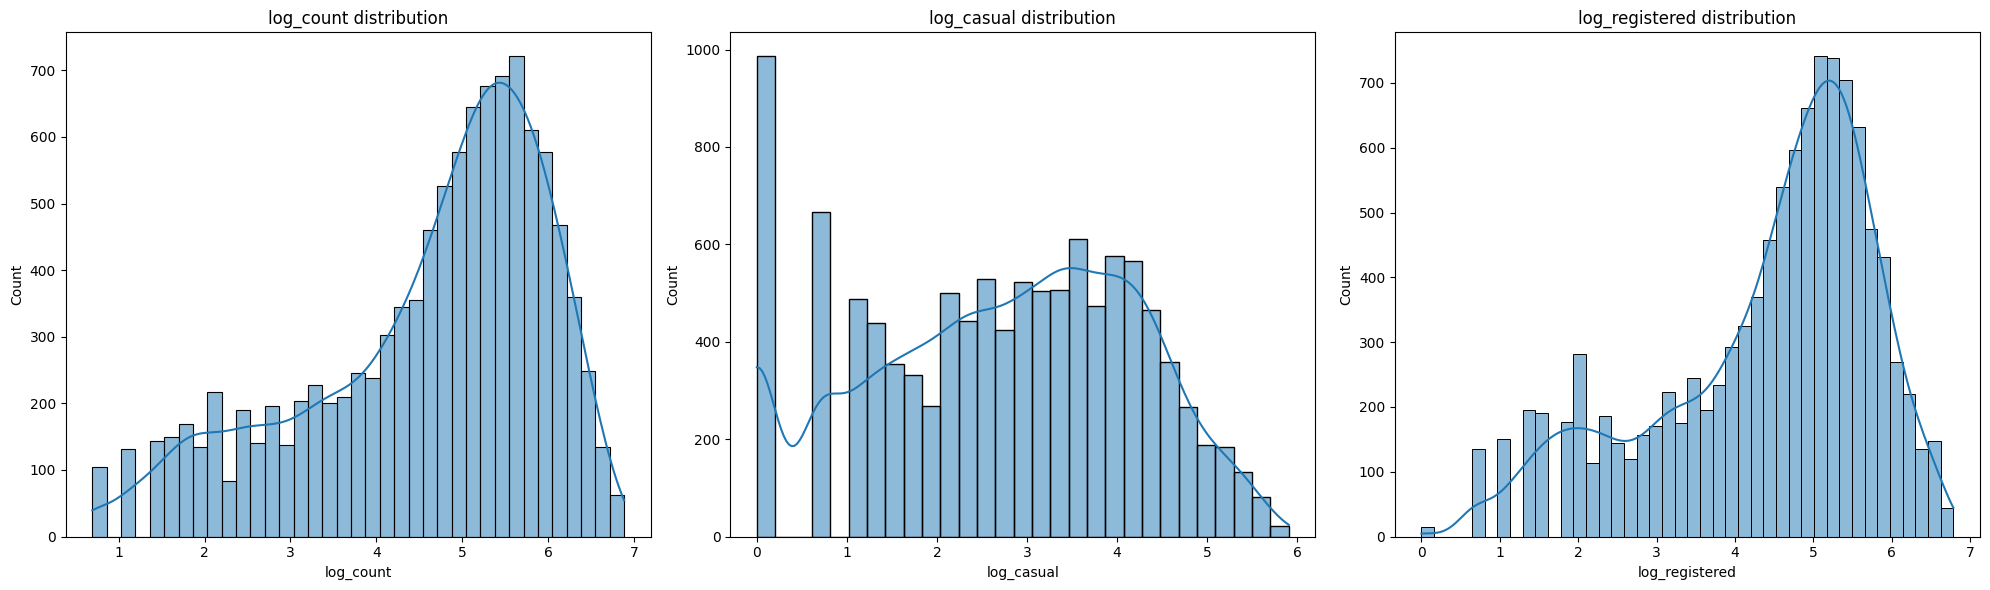

In [20]:
# Configure the size of the plot
plt.figure(figsize=(20, 6))

# Initialize the counter
counter = 1

for col in ['log_count', 'log_casual', 'log_registered']:
    plt.subplot(1, 3, counter)
    sns.histplot(train_data_df[col], kde=True)
    plt.title(f'{col} distribution')
    counter += 1

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
train_data_df.sample(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,hour,log_count,log_casual,log_registered
3379,3,0,1,1,34.44,35.605,26,19.9995,2011,8,2,17,6.371612,4.276666,6.242223
10433,4,0,0,2,10.66,13.635,81,8.9981,2012,12,5,3,2.772589,0.693147,2.708050
9348,3,0,1,1,24.60,30.305,60,8.9981,2012,9,2,21,5.726848,3.332205,5.634790
10349,4,0,1,1,17.22,21.210,38,8.9981,2012,11,4,15,5.590987,3.433987,5.472271
7319,2,0,1,1,22.96,26.515,88,0.0000,2012,5,4,8,6.428105,3.555348,6.371612
5814,1,0,1,2,13.94,17.425,87,7.0015,2012,1,1,11,4.330733,1.098612,4.304065
3477,3,0,0,1,29.52,34.850,74,15.0013,2011,8,6,19,5.560682,4.330733,5.220356
8209,3,0,1,1,33.62,37.120,43,15.0013,2012,7,1,10,5.347108,4.043051,5.036953
5253,4,0,1,1,9.84,14.395,75,0.0000,2011,12,0,23,3.828641,1.386294,3.761200
2399,2,0,1,1,29.52,34.090,70,8.9981,2011,6,1,21,5.389072,3.465736,5.236442


Is important to note that the column `count` as the target variable, should be transformed back to its original scale after doing predictions with the model.

## Correlation Analysis

In order to understand the relationship between the target variable and the features, we can calculate the correlation matrix. This will help to identify the most important features for the model, and also to identify possible multicollinearity issues.

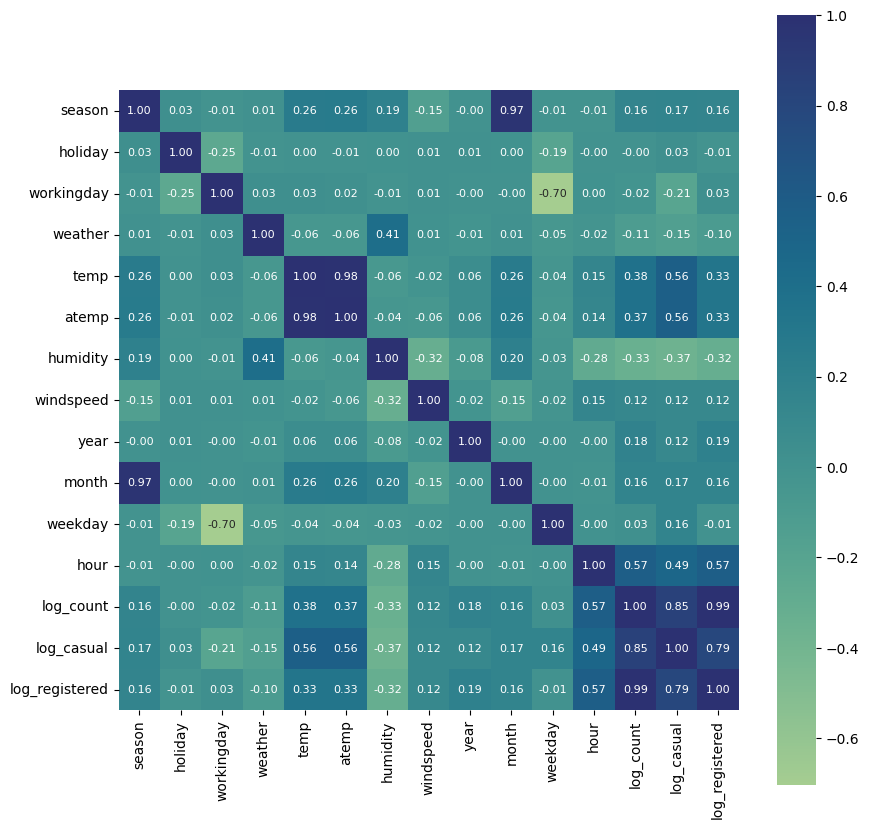

In [17]:
# Calculate the correlation matrix
corr = train_data_df.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 8}, cmap='crest')
plt.show()

We can see that some variables are highly correlated with each other. To avoid multicollinearity, we can drop from this variables, the ones that are less correlated with the target variable `log_count`. In this case, we consider high correlation above 0.85.

In [23]:
high_corr_pairs = [
                    # Pair of columns with correlation value
                    (col1, col2) for col1 in corr.columns for col2 in corr.columns 
                    # Ensure the pair is unique and the correlation value is greater than 0.85
                    if col1 != col2 and abs(corr.loc[col1, col2]) > 0.85 
                    # Ensure the pair is not already in the list and not containing the target column
                    and 'log_count' not in (col1, col2)
                ]

print(f'Highly correlated pairs: \n{high_corr_pairs}')

Highly correlated pairs: 
[('season', 'month'), ('temp', 'atemp'), ('atemp', 'temp'), ('month', 'season')]


Determine which variables to drop

In [25]:
to_drop = set()

for col1, col2 in high_corr_pairs:
    # Drop the column with the least correlation with the target
    if abs(corr.loc[col1, 'log_count']) > abs(corr.loc[col2, 'log_count']):
        to_drop.add(col2)
    else:
        to_drop.add(col1)

# Drop the identified columns
train_data_df = train_data_df.drop(columns=to_drop)

train_data_df.head()

,holiday,workingday,weather,temp,humidity,windspeed,year,month,weekday,hour,log_count,log_casual,log_registered
0,0,0,1,9.84,81,0.0,2011,1,5,0,2.833213,1.386294,2.639057
1,0,0,1,9.02,80,0.0,2011,1,5,1,3.713572,2.197225,3.496508
2,0,0,1,9.02,80,0.0,2011,1,5,2,3.496508,1.791759,3.332205
3,0,0,1,9.84,75,0.0,2011,1,5,3,2.639057,1.386294,2.397895
4,0,0,1,9.84,75,0.0,2011,1,5,4,0.693147,0.000000,0.693147


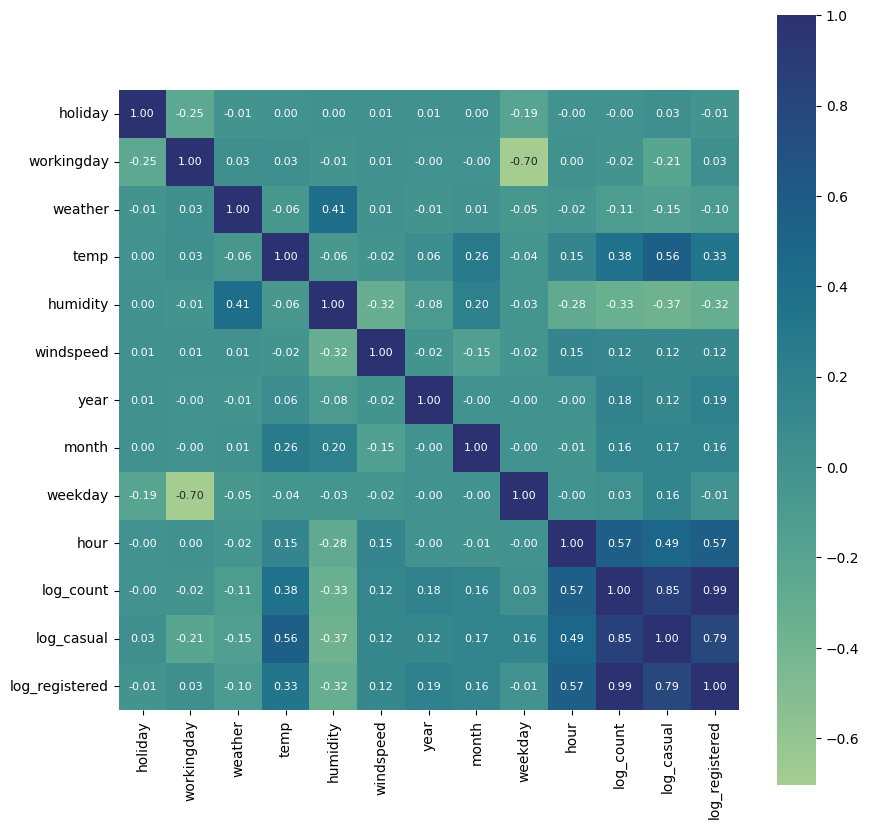

In [26]:
# Calculate the correlation matrix
corr = train_data_df.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 8}, cmap='crest')
plt.show()

In [27]:
# Get the top 5 columns most correlated with 'count'
top_5_corr = corr['log_count'].abs().sort_values(ascending=False).head(6)  # Including 'count' itself

# Drop 'count' from the list
top_5_corr = top_5_corr.drop('log_count')

# Display the top 5 columns
print("Top 5 columns most correlated with 'count':")
print(top_5_corr)

Top 5 columns most correlated with 'count':
log_registered    0.992579
log_casual        0.847033
hour              0.570638
temp              0.376587
humidity          0.333158
Name: log_count, dtype: float64
